Analysis of Gridded Ensemble Precipitation and Temperature Estimates over the Contiguous United States
====

For this example, we'll work with 100 member ensemble of precipitation and temperature data. 

Link to dataset: https://www.earthsystemgrid.org/dataset/gridded_precip_and_temp.html

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import dask
from distributed.utils import format_bytes

### Connect to Dask Distributed Cluster

In [2]:
from dask.distributed import Client
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(memory="40GB", cores=1, processes=1)
cluster.adapt(minimum=20, maximum=40, wait_count=120)
cluster

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [3]:
client = Client(cluster)
dask.config.set({'distributed.dashboard.link': 'http:localhost:8777/proxy/{port}/status'})
client

Client Scheduler: tcp://10.12.205.200:42917 Dashboard: http:localhost:8777/proxy/8787/status,Cluster Workers: 20 Cores: 20 Memory: 800.00 GB


### Open Dataset

We'll load the dataset using a package called  [Intake-esm](https://intake-esm.readthedocs.io/en/latest/) which is a plugin for intake. Intake provides data catalog and ingesting capabilities that let us skip the some the boilerplate and get to work with our dataset. Under the hood, this dataset is stored using [netCDF](https://www.unidata.ucar.edu/software/netcdf/) format. 

The dataset has dimensions of time, latitude, longitude, and ensmemble member.

In [4]:
### Load with intake
import intake
col = intake.open_esm_metadatastore(collection_name="GLADE-GMET")
col.df.head()

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


,resource,resource_type,direct_access,frequency,member_id,version,time_range,resolution,file_fullpath,file_basename,file_dirname
0,v1_landmask:GMET_V1:posix:/glade/p/ral/hap/ane...,posix,True,daily,68,v1,19810101-19811231,eighth,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...,conus_daily_eighth_19810101_19811231_068.nc4,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...
1,v1_landmask:GMET_V1:posix:/glade/p/ral/hap/ane...,posix,True,daily,91,v1,20130101-20131231,eighth,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...,conus_daily_eighth_20130101_20131231_091.nc4,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...
2,v1_landmask:GMET_V1:posix:/glade/p/ral/hap/ane...,posix,True,daily,17,v1,20000101-20001231,eighth,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...,conus_daily_eighth_20000101_20001231_017.nc4,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...
3,v1_landmask:GMET_V1:posix:/glade/p/ral/hap/ane...,posix,True,daily,71,v1,20060101-20061231,eighth,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...,conus_daily_eighth_20060101_20061231_071.nc4,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...
4,v1_landmask:GMET_V1:posix:/glade/p/ral/hap/ane...,posix,True,daily,75,v1,20070101-20071231,eighth,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...,conus_daily_eighth_20070101_20071231_075.nc4,/glade/p/ral/hap/anewman/conus_v1p2/eighth/v1_...


/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [5]:
cat = col.search(version="v1")
%time ds = cat.to_xarray(chunks={'time': 366})


CPU times: user 17.6 s, sys: 1.39 s, total: 19 s
Wall time: 44.3 s


In [6]:
# Print dataset
ds

<xarray.Dataset>
Dimensions:    (lat: 224, lon: 464, member_id: 100, time: 13515)
Coordinates:
  * lat        (lat) float64 25.12 25.25 25.38 25.5 ... 52.62 52.75 52.88 53.0
  * lon        (lon) float64 -124.9 -124.8 -124.6 -124.5 ... -67.25 -67.12 -67.0
  * time       (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2016-12-31
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100
Data variables:
    elevation  (lat, lon) float64 dask.array<shape=(224, 464), chunksize=(224, 464)>
    pcp        (member_id, time, lat, lon) float32 dask.array<shape=(100, 13515, 224, 464), chunksize=(1, 366, 224, 464)>
    t_mean     (member_id, time, lat, lon) float32 dask.array<shape=(100, 13515, 224, 464), chunksize=(1, 366, 224, 464)>
    t_range    (member_id, time, lat, lon) float32 dask.array<shape=(100, 13515, 224, 464), chunksize=(1, 366, 224, 464)>
Attributes:
    references:   Newman et al. 2015: Gridded Ensemble Precipitation and Temp...
    source:       Generated usi

### Figure: Elevation and domain mask

A quick plot of the mask to give us an idea of our spatial domain

Text(0.5, 1.0, 'Domain Elevation')

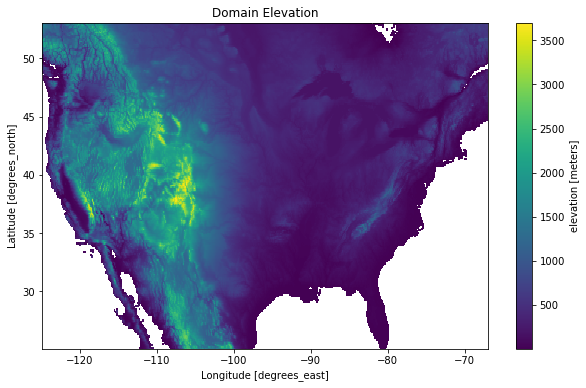

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [7]:
elevation = ds['elevation']
elevation = elevation.where(elevation > 0).load()
elevation.plot(figsize=(10, 6))
plt.title('Domain Elevation')

### Quantify the ensemble uncertainty for a single day

This dataset provides 100 equally likely realizations of the temperature/precipitation that could have occured, given the station-observed weather. We can quantify the uncertaintly that comes from observation and gridding errors like this:

In [8]:
temp = ds['t_mean'].sel(time='1984-07-31')
temp_ens_mean = temp.mean('member_id')
temp_errors = temp - temp_ens_mean
temp_std_errors = temp_errors.std('member_id')

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


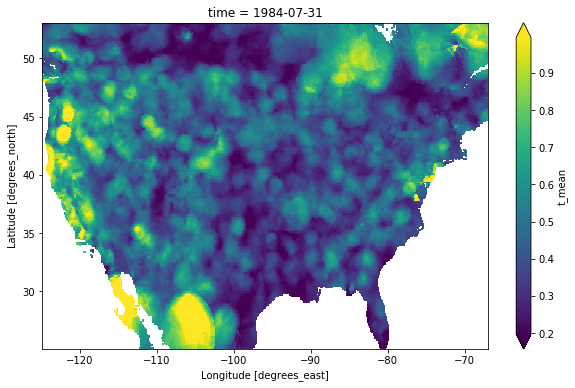

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [9]:
temp_std_errors.plot(robust=True, figsize=(10, 6))

As we can see, remote and topographically complex areas tend to have larger uncertainties in this dataset.

### Intra-ensemble range

We calculate the intra-ensemble range for all the mean daily temperature in this dataset.  This gives us a sense of uncertainty.

In [10]:
temp_mean = ds['t_mean'].mean(dim='time')
spread = (temp_mean.max(dim='member_id')
        - temp_mean.min(dim='member_id'))
spread

<xarray.DataArray 't_mean' (lat: 224, lon: 464)>
dask.array<shape=(224, 464), dtype=float32, chunksize=(224, 464)>
Coordinates:
  * lat      (lat) float64 25.12 25.25 25.38 25.5 ... 52.62 52.75 52.88 53.0
  * lon      (lon) float64 -124.9 -124.8 -124.6 -124.5 ... -67.25 -67.12 -67.0

### Calling compute
The expressions above didn't actually compute anything. They just build the task graph. To do the computations, we call the `compute` or `persist` methods:

In [11]:
spread = spread.persist(retries=2)
spread

<xarray.DataArray 't_mean' (lat: 224, lon: 464)>
dask.array<shape=(224, 464), dtype=float32, chunksize=(224, 464)>
Coordinates:
  * lat      (lat) float64 25.12 25.25 25.38 25.5 ... 52.62 52.75 52.88 53.0
  * lon      (lon) float64 -124.9 -124.8 -124.6 -124.5 ... -67.25 -67.12 -67.0

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


#### Figure: Intra-ensemble range


Text(0.5, 1.0, 'Intra-ensemble range in mean annual temperature')

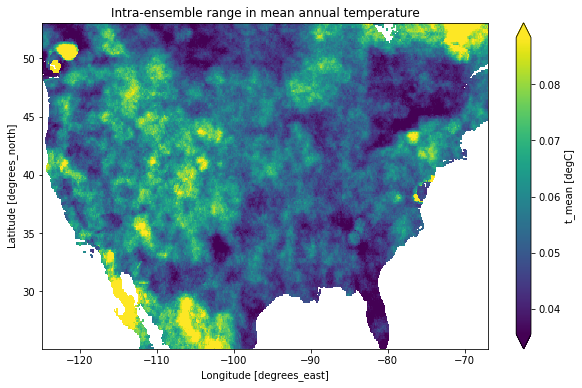

In [12]:
spread.attrs['units'] = 'degC'
spread.plot(robust=True, figsize=(10, 6))
plt.title('Intra-ensemble range in mean annual temperature')

### Average seasonal snowfall

We can compute a crude estimate of average seasonal snowfall using the temperature and precipitation variables in our dataset. Here, we'll look at the first 4 ensemble members and make some maps of the seasonal total snowfall in each ensemble member.

In [14]:
da_snow = ds['pcp'].where(ds['t_mean'] < 0.).resample(time='QS-Mar').sum('time')
seasonal_snow = da_snow.isel(member_id=slice(0, 4)).groupby('time.season').mean('time').persist()

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")
/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [15]:
# properly sort the seasons
seasonal_snow = seasonal_snow.sel(season=['DJF', 'MAM','JJA', 'SON'])
seasonal_snow.attrs['units'] = 'mm/season'
seasonal_snow

<xarray.DataArray 'pcp' (member_id: 4, season: 4, lat: 224, lon: 464)>
dask.array<shape=(4, 4, 224, 464), dtype=float32, chunksize=(1, 1, 224, 464)>
Coordinates:
  * lat        (lat) float64 25.12 25.25 25.38 25.5 ... 52.62 52.75 52.88 53.0
  * lon        (lon) float64 -124.9 -124.8 -124.6 -124.5 ... -67.25 -67.12 -67.0
  * member_id  (member_id) int64 1 2 3 4
  * season     (season) object 'DJF' 'MAM' 'JJA' 'SON'
Attributes:
    units:    mm/season

#### Figure: Average seasonal snowfall totals 

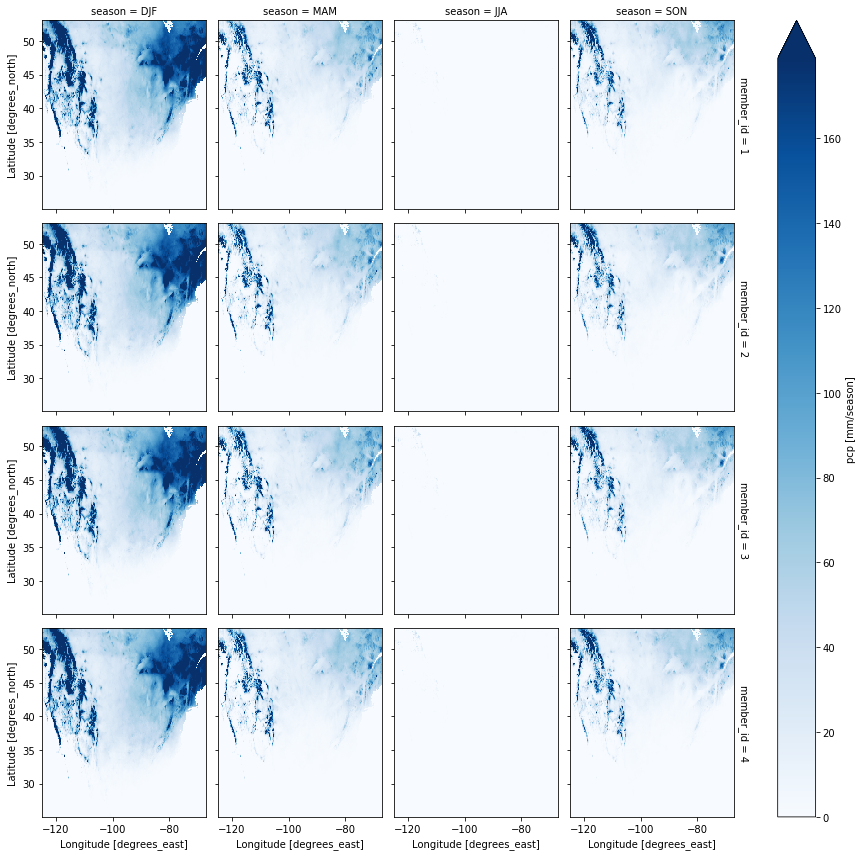

In [16]:
seasonal_snow.plot.pcolormesh(col='season', row='member_id', cmap='Blues', robust=True)

### Extract a time series of annual maximum precipitation events over a region

In the previous two examples, we've mostly reduced the time and/or ensemble dimension. Here, we'll do a reduction operation on the spatial dimension to look at a time series of extreme precipitation events near Austin, TX (30.2672° N, 97.7431° W).

In [17]:
buf = 0.25  # look at Austin +/- 0.25 deg

ds_tx = ds.sel(lon=slice(-97.7431-buf, -97.7431+buf), lat=slice(30.2672-buf, 30.2672+buf))

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


In [18]:
pcp_ann_max = ds_tx['pcp'].resample(time='AS').max('time')

In [19]:
pcp_ann_max_ts = pcp_ann_max.max(('lat', 'lon')).persist()
pcp_ann_max_ts

<xarray.DataArray 'pcp' (member_id: 100, time: 37)>
dask.array<shape=(100, 37), dtype=float32, chunksize=(1, 1)>
Coordinates:
  * time       (time) datetime64[ns] 1980-01-01 1981-01-01 ... 2016-01-01
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100

/glade/work/abanihi/softwares/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/scheduler.py:313: UserWarning: WorkerState.ncores has moved to WorkerState.nthreads
  warnings.warn("WorkerState.ncores has moved to WorkerState.nthreads")


#### Figure: Timeseries of maximum precipitation near Austin, Tx.

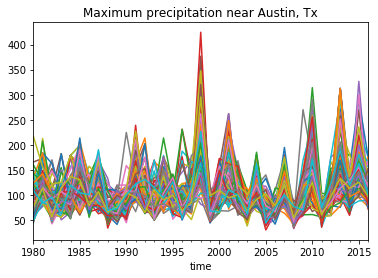

In [ ]:
ax = pcp_ann_max_ts.transpose().to_pandas().plot(title='Maximum precipitation near Austin, Tx', 
                                                 legend=False)

In [6]:
cluster.close()
client.close()